In [1]:
import openturns as ot
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from shapley import SobolIndices, SobolKrigingIndices, create_df_from_gp_indices, create_df_from_mc_indices
from shapley.tests import Ishigami
from shapley.plots import set_style_paper, plot_violin

%load_ext autoreload
%autoreload 2

%matplotlib inline

set_style_paper()

savefigs = False

## The model

In [2]:
ishigami = Ishigami()
dim = ishigami.ndim
model = ishigami

## Sobol indices with a classical Monte-Carlo sampling

In [8]:
%%time
ot.RandomGenerator.SetSeed(0)
np.random.seed(0)
n_sample = 10000
n_boot = 500
estimator = 'sobol2002'

# Indice calculation
sobol = SobolIndices(ishigami.input_distribution)
sobol.build_mc_sample(model=model, n_sample=n_sample)
sobol_results = sobol.compute_indices(n_boot=n_boot, estimator=estimator)
sobol_results.true_indices = ishigami.indices

# Results
first_indices_mc = sobol_results.first_indices
total_indices_mc = sobol_results.total_indices

print("Sobol indices:", first_indices_mc)
print("Total Sobol indices:", total_indices_mc)

Sobol indices: [ 0.31371917  0.41064923 -0.00836304]
Total Sobol indices: [ 0.53452577  0.47135063  0.24019769]
Wall time: 835 ms


Let's see how it looks like in the plot

In [9]:
def plot_violin(results, ax=None):
    df_indices = results.df_indices
    viol_plot = sns.violinplot(x='Variables', y='Indice values', hue='Indices', data=df_indices, ax=ax)
    
    if results.true_indices:        
        true_indices = results.true_indices
        palette = {'True first': "y", 'True total': "m"}
        sns.stripplot(x='Variables', y='Indice values', data=true_indices, hue='Indices', ax=ax, 
                      dodge=True, palette=palette, size=9);
    return ax

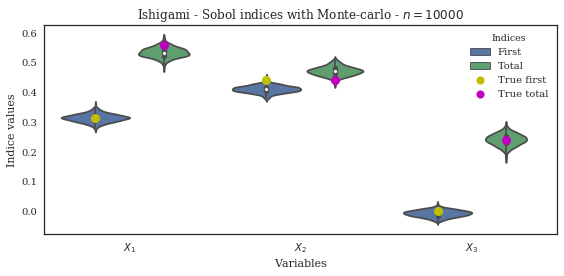

In [11]:
fig, ax = plt.subplots(figsize=(8, 4))
df_indices = sobol_results.df_indices
true_indices = sobol_results.true_indices
palette = {'True first': "y", 'True total': "m"}
viol_plot = sns.violinplot(x='Variables', y='Indice values', hue='Indices', data=df_indices, ax=ax)
sns.stripplot(x='Variables', y='Indice values', data=true_indices, hue='Indices', ax=ax, dodge=True, palette=palette, size=9);
ax.set_title("Ishigami - Sobol indices with Monte-carlo - $n=%d$" % (n_sample))
fig.tight_layout()
if savefigs:
    fig.savefig('./output/ishigami_1st_sobol_MC.pdf')

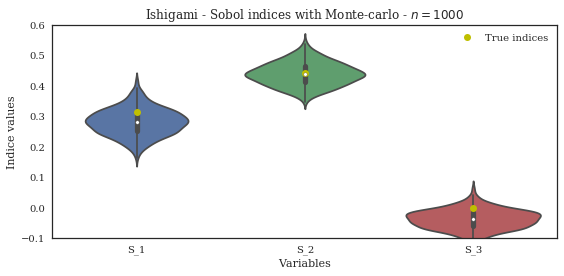

In [14]:
df_first_indices_mc = sobol_results.df_first_indices
fig, ax = plt.subplots(figsize=(8, 4))
plot_violin(df_first_indices_mc, with_hue=False, true_indices=ishigami.first_order_sobol_indices, ylim=ylim, ax=ax)
ax.set_title("Ishigami - Sobol indices with Monte-carlo - $n=%d$" % (n_sample))
fig.tight_layout()
if savefigs:
    fig.savefig('./output/ishigami_1st_sobol_MC.pdf')

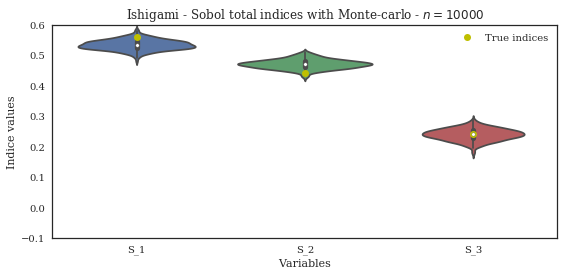

In [10]:
df_total_indices_mc = create_df_from_mc_indices(total_indices_mc)
fig, ax = plt.subplots(figsize=(8, 4))
plot_violin(df_total_indices_mc, with_hue=False, true_indices=ishigami.total_sobol_indices, ylim=ylim, ax=ax)
ax.set_title("Ishigami - Sobol total indices with Monte-carlo - $n=%d$" % (n_sample))
fig.tight_layout()
if savefigs:
    fig.savefig('./output/ishigami_total_sobol_MC.pdf')

## Using a Kriging model to substitute the true model

### Building the model

In [54]:
ot.RandomGenerator.SetSeed(0)
np.random.seed(0)
model_budget = 50
basis = 'linear'
kernel = 'exponential'
library = 'OT'
sobol_kriging = SobolKrigingIndices(input_distribution)
meta_model = sobol_kriging.build_meta_model(model, n_sample=model_budget, basis_type=basis, kernel=kernel, library=library)

### The quality of the kriging model

#### With Leave One Out

In [55]:
score_q2_loo = meta_model.compute_score_q2_loo()
print('Leave One Out Q2 score:', score_q2_loo)

Leave One Out Q2 score: 0.438907822494


#### With cross validation

In [56]:
n_sample_cv = 20000
score_q2_cv = meta_model.compute_score_q2_cv(n_sample_cv, sampling='lhs')
print('Cross Validation Q2 score with %d observations:' % (n_sample_cv), score_q2_cv)

Cross Validation Q2 score with 20000 observations: 0.532566240261


### Estimating the indices

In [64]:
%%time
n_sample = 1000
n_realization = 300
sobol_kriging.build_mc_sample(meta_model, n_sample, n_realization)
first_indices_gp = sobol_kriging.compute_indices(n_boot=n_boot, estimator='janon2')
df_first_indices_gp = create_df_from_gp_indices(first_indices_gp)

Wall time: 59.7 s


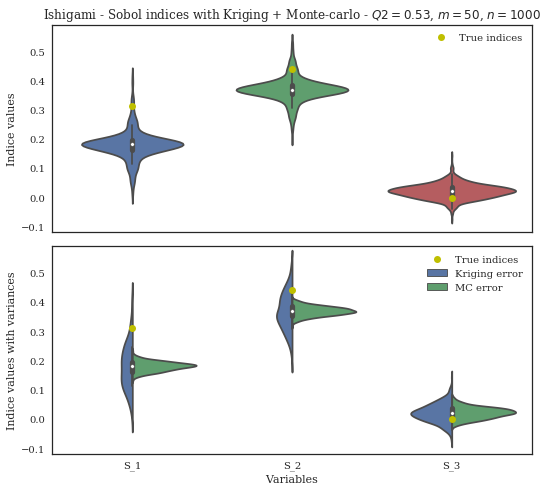

In [76]:
fig, axes = plt.subplots(2, 1, figsize=(8, 7), sharex=True, sharey=True)

ax = axes[0]
plot_violin(df_first_indices_gp, with_hue=False, true_indices=ishigami.first_order_sobol_indices, ax=ax)
ax.set_xlabel('')
ax.set_title("Ishigami - Sobol indices with Kriging + Monte-carlo - $Q2=%.2f$, $m=%d$, $n=%d$" % (score_q2_cv, model_budget, n_sample))

ax = axes[1]
plot_violin(df_first_indices_gp, with_hue=True, true_indices=ishigami.first_order_sobol_indices, ax=ax)
ax.set_ylabel('Indice values with variances')
fig.tight_layout()
if savefigs:
    fig.savefig('./output/ishigami_1st_sobol_kriging_MC.pdf')

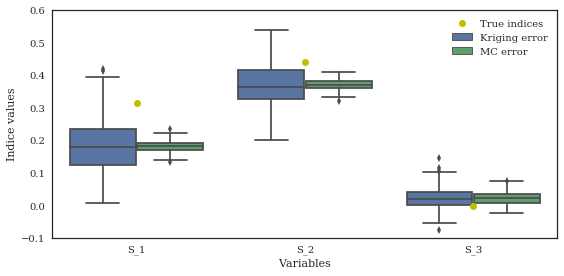

In [66]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.boxplot(x='Variables', y='Indice values', data=df_first_indices_gp, hue='Error', ax=ax)
ax.plot(ishigami.first_order_sobol_indices, 'yo', markersize=7, label='True indices')
ax.legend(loc=0)
ax.set_ylim(ylim)
fig.tight_layout()